In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from datetime import timedelta, date

In [2]:
covid = pd.read_csv("covid_19_data.csv")
covid["ObservationDate"] = pd.to_datetime(covid["ObservationDate"])
covid.drop(columns=["SNo"], inplace=True)
covid.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
covid.describe()

,Confirmed,Deaths,Recovered
count,2943.000000,2943.000000,2943.000000
mean,611.235134,17.255522,144.190962
std,5065.424601,179.644743,1342.366267
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,11.000000,0.000000,1.000000
75%,122.000000,1.000000,18.000000
max,66907.000000,2761.000000,31536.000000


In [4]:
covid.groupby(['Country/Region']).sum().sort_values(["Confirmed"],ascending=False).head()

,Confirmed,Deaths,Recovered
Country/Region,,,
Mainland China,1749258.0,50139.0,419703.0
South Korea,15900.0,100.0,313.0
Others,10781.0,41.0,54.0
Italy,5662.0,136.0,228.0
Japan,2668.0,34.0,380.0


# We want, initiallly, only data from China

In [5]:
china = covid[covid["Country/Region"] == "Mainland China"]
china.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [6]:
china_provinces = china.groupby(
    ["ObservationDate","Province/State"], as_index=False).sum().sort_values(
    ["ObservationDate","Confirmed"], ascending=[1,0])[
    ["ObservationDate","Province/State","Confirmed","Deaths","Recovered"]]
china_provinces.head()

,ObservationDate,Province/State,Confirmed,Deaths,Recovered
12,2020-01-22,Hubei,444.0,17.0,28.0
5,2020-01-22,Guangdong,26.0,0.0,0.0
1,2020-01-22,Beijing,14.0,0.0,0.0
30,2020-01-22,Zhejiang,10.0,0.0,0.0
23,2020-01-22,Shanghai,9.0,0.0,0.0


In [7]:
china_provinces.groupby("Province/State").sum().sort_values("Confirmed", ascending=False).head()

,Confirmed,Deaths,Recovered
Province/State,,,
Hubei,1405978.0,48223.0,284458.0
Guangdong,36981.0,96.0,13579.0
Zhejiang,34309.0,11.0,14200.0
Henan,33813.0,372.0,14860.0
Hunan,27860.0,70.0,12936.0


## Let's see only some Provinces in a graph

In [8]:
def testa_provincia(prov_name):
    prov = china_provinces[china_provinces["Province/State"] == prov_name]
    prov.plot(x="ObservationDate", y=["Confirmed","Deaths","Recovered"],title="Evolution of COVID-19 - " + prov_name)
    plt.show()
    prov_dif = prov.groupby("ObservationDate").sum()
    prov_dif[["Confirmed_dif","Deaths_dif","Recovered_dif"]] = prov_dif[["Confirmed","Deaths","Recovered"]] - prov_dif[["Confirmed","Deaths","Recovered"]].shift()
    prov_dif.plot(y=["Confirmed_dif"],
                   title="Evolution of COVID-19 daily sum - " + prov_name)
    plt.show()

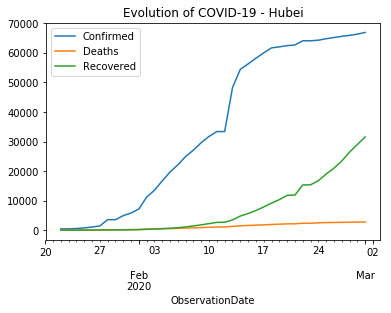

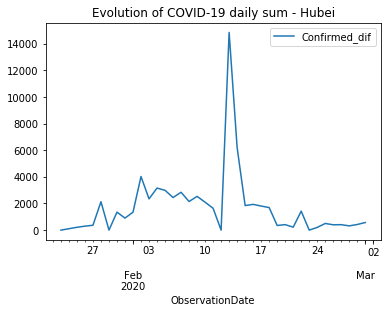

In [9]:
testa_provincia("Hubei")

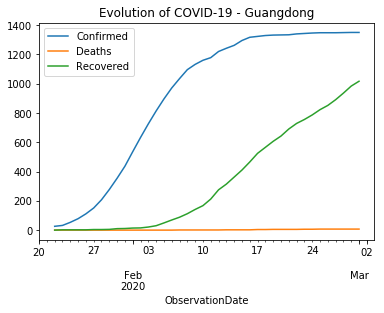

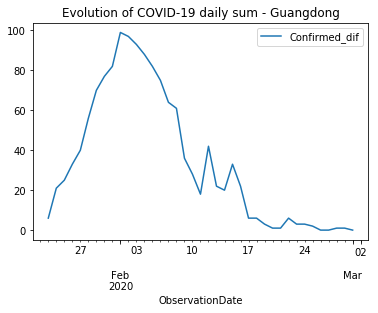

In [10]:
testa_provincia("Guangdong")

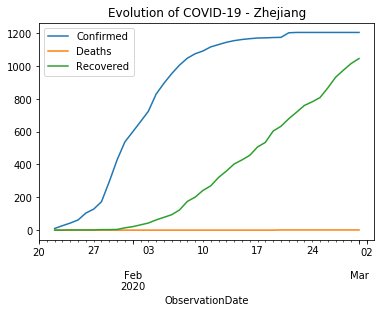

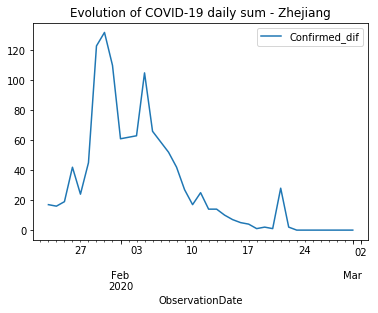

In [11]:
testa_provincia("Zhejiang")

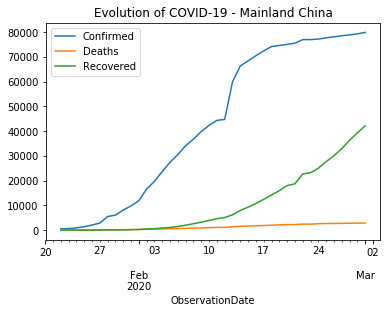

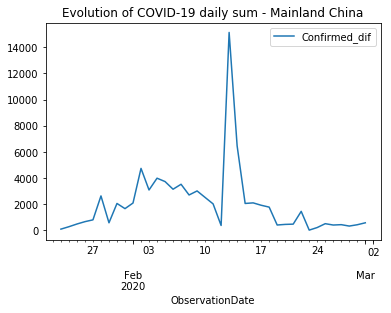

In [12]:
china_provinces.groupby("ObservationDate",as_index=False).sum().plot(x="ObservationDate", y=["Confirmed","Deaths","Recovered"],title="Evolution of COVID-19 - " + "Mainland China")
plt.show()
china_provinces_dif = china_provinces.groupby("ObservationDate").sum()
china_provinces_dif[["Confirmed_dif","Deaths_dif","Recovered_dif"]] = china_provinces_dif[["Confirmed","Deaths","Recovered"]] - china_provinces_dif[["Confirmed","Deaths","Recovered"]].shift()
china_provinces_dif.plot(y=["Confirmed_dif"],
               title="Evolution of COVID-19 daily sum - " + "Mainland China")
plt.show()

# Fitting a continuous  function to the incidence

We want to fit $$\mbox{Incidence}_{\mbox{DENV}}=c_1\exp\left[-\frac{\left(t-c_2\right)^2}{c_3}\right]+c_4$$

to the data.

In [78]:
china_test = china_provinces.groupby("ObservationDate",as_index=False).sum()

In [79]:
ydata = np.array([x for x in china_test['Confirmed'].tolist()])

In [80]:
def incidence_denv(xdata, c1, c2, c3,c4):
    ans = [c1 * np.exp(-((t-c2)**2)/c3) + c4 for t in xdata]
    return ans

In [81]:
china_test['Date_T'] = pd.to_timedelta(china_test['ObservationDate']).dt.days - 18282

In [86]:
ans = curve_fit(incidence_denv,np.transpose(np.array([x for x in china_test['Date_T'].tolist()])),
                np.transpose(np.array([x for x in china_test['Confirmed'].tolist()])), 
                p0 = [100000., 61, 400.,0],
                bounds = ((40000,10,0,0),(1000000,150,800,30000))
               )

In [87]:
ans

(array([8.15720243e+04, 3.39991765e+01, 3.08495206e+02, 3.31129868e-13]),
 array([[ 4.28316648e+06,  3.13814634e+02,  4.07866119e+04,
         -3.81803257e+06],
        [ 3.13814634e+02,  2.00763443e-01,  1.00459024e+01,
         -3.25812246e+02],
        [ 4.07866119e+04,  1.00459024e+01,  9.52627384e+02,
         -5.23830066e+04],
        [-3.81803257e+06, -3.25812246e+02, -5.23830066e+04,
          4.43709759e+06]]))

In [88]:
c1, c2, c3,c4 = ans[0]
ans[0]

array([8.15720243e+04, 3.39991765e+01, 3.08495206e+02, 3.31129868e-13])

### Estimating

In [89]:
sample_size = int(china_test['Date_T'].max().astype(int))

In [90]:
past_forecast = china_test['ObservationDate'].append(china_test['ObservationDate'] + timedelta(days=sample_size))

china_test_forecast = pd.DataFrame()
china_test_forecast['Date_T'] = pd.to_timedelta(past_forecast).dt.days - 18282
china_test_forecast['ObservationDate'] = past_forecast
china_test_forecast['Confirmed'] = china_test_forecast['Date_T'].apply(lambda t: c1 * np.exp(-((t-c2)**2)/c3)+c4 )

In [91]:
to_plot = pd.DataFrame()
to_plot[['ObservationDate','Confirmed_forecast']] = china_test_forecast[['ObservationDate',"Confirmed"]]
to_plot = to_plot.merge(china_test[['ObservationDate','Confirmed']],on='ObservationDate',how='left')

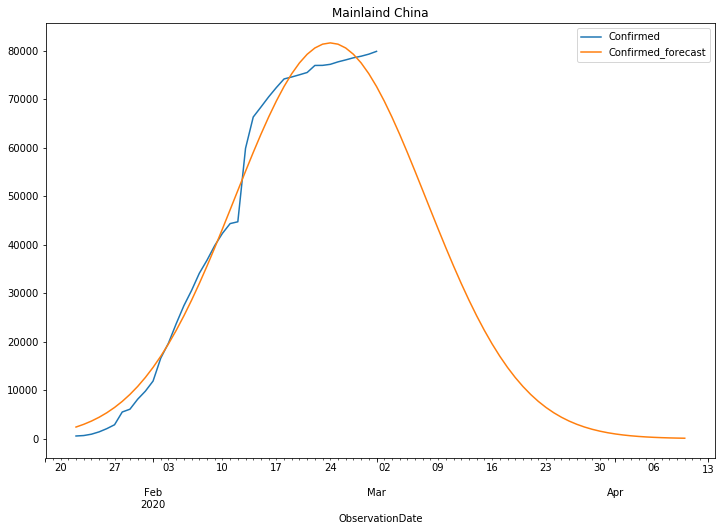

In [92]:
to_plot.plot(x='ObservationDate',y=['Confirmed','Confirmed_forecast'],figsize=(12,8),title='Mainlaind China')
plt.show()